# How to Schedule Cost Effective Santa Workshop Tours?

Seems like the Santa underestimated the families enthusiasm! In order to make everyone happy and not blow a hole in his pocket, lets show Santa some plots to help him understanding his financial costs!

#### Key Discussions : 
- How big are the families interested in the tour?
- How much would the consolation gifts cost the Santa, if families can't get their preferred choices?
- How does the accounting cost behave, given different combination of tour plans?

#### **Important Update:**
- Fixed the formula for accounting cost, in the previous version, the absolute of difference was not taken.
- Fixed the exponent formula (+ instead of -), seems like the evaluation metric page got updated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('../input/santa-workshop-tour-2019/family_data.csv')

In [2]:
def get_cost_by_choice(num_members):
    
    '''
    Input : num_members
    Output : [(choice number indices),(corresponding cost)]
    '''
    
    
    cost_by_choice = {}
    
    cost_by_choice[1] = 50
    cost_by_choice[2] = 50 + 9 * num_members
    cost_by_choice[3] = 100 + 9 * num_members
    cost_by_choice[4] = 200 + 9 * num_members
    cost_by_choice[5] = 200 + 18 * num_members
    cost_by_choice[6] = 300 + 18 * num_members
    cost_by_choice[7] = 400 + 36 * num_members
    cost_by_choice[8] = 500 + (36 + 199) * num_members
    cost_by_choice[9] = 500 + (36 + 398) * num_members
    
    return list(zip(*cost_by_choice.items()))

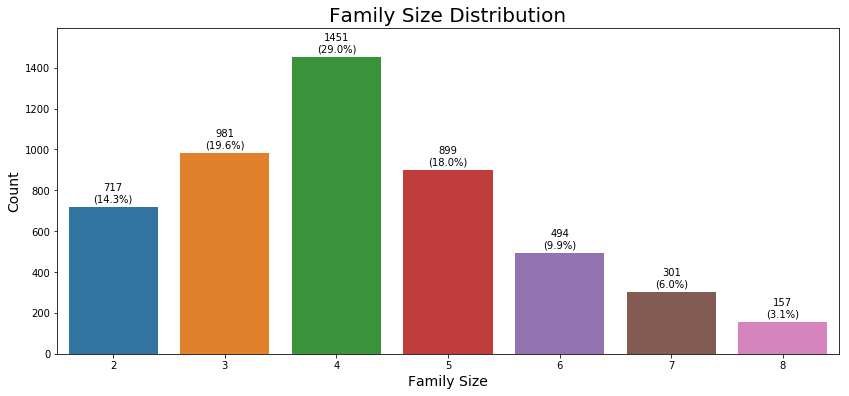

In [3]:
family_size = df['n_people'].value_counts().sort_index()

plt.figure(figsize=(14,6))
ax = sns.barplot(x=family_size.index, y=family_size.values)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}\n({p.get_height() / sum(family_size) * 100:.1f}%)', 
                xy=(p.get_x() + p.get_width()/2., p.get_height()), ha='center', xytext=(0,5), textcoords='offset points')
    
ax.set_ylim(0, 1.1*max(family_size))
plt.xlabel('Family Size', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Family Size Distribution', fontsize=20)
plt.show()

### Insight #1:
Santa : "Seems like family of 4 is the norm nowadays. Luckily, there are only a few huge families!"

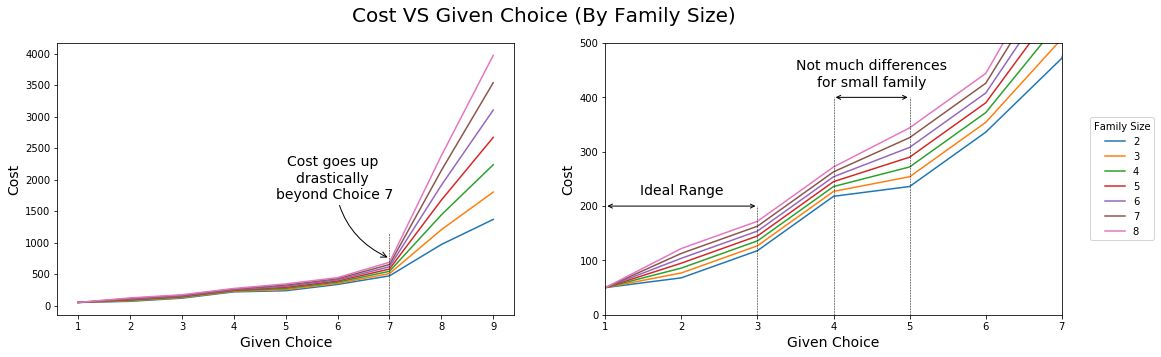

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,5))

for num in range(2,9,1):
    indices, cost = get_cost_by_choice(num)
    ax1.plot(indices, cost, label=f'{num}')
    ax2.plot(indices, cost, label=f'{num}')

ax1.axvline(x=7, ymax=0.3, ls='--', lw=0.5, color='black')
ax1.annotate(f'Cost goes up \ndrastically \nbeyond Choice 7',
             (7, 750), 
             textcoords ='offset points',
             xytext =(-55,80), 
             ha='center',
             va='center', 
             fontsize=14, 
             color='black',
             arrowprops=dict(arrowstyle='->', 
                             connectionstyle='arc3,rad=0.3', 
                             color='black'))

ax2.annotate(s='', xy=(1,200), xytext=(3,200), xycoords ='data', arrowprops=dict(arrowstyle='<->'))
ax2.annotate(s='Ideal Range', xy=(2,220), xycoords ='data', ha='center', fontsize=14)
ax2.axvline(x=3, ymax=0.4, ls='--', lw=0.5, color='black')

ax2.annotate(s='', xy=(4,400), xytext=(5,400), xycoords ='data', arrowprops=dict(arrowstyle='<->'))
ax2.annotate(s='Not much differences\nfor small family', xy=(4.5,420), xycoords ='data', ha='center', fontsize=14)
ax2.axvline(x=4, ymax=0.8, ls='--', lw=0.5, color='black')
ax2.axvline(x=5, ymax=0.8, ls='--', lw=0.5, color='black')

ax1.set_ylabel('Cost', fontsize=14)
ax2.set_ylabel('Cost', fontsize=14)
ax1.set_xlabel('Given Choice', fontsize=14)
ax2.set_xlabel('Given Choice', fontsize=14)
ax2.set_ylim(0,500)
ax2.set_xlim(1,7)

plt.suptitle('Cost VS Given Choice (By Family Size)', fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title='Family Size')
plt.show()

### Insight #2:

Santa : "How can I spend less on the consolation gifts, so that I can get more toys this year?"
- Try to schedule the families for their top 3 choices
- Anything beyond **Choice 7** is a BIG NO as Santa got to spend LOADS of money just to console them. (Santa, in deep thoughts : "Maybe I should just tell them to try again next year...")
- For smaller families, assigning them to **Choice 4 or 5** doesn't make much difference, just another 25% off the Santa Buffet per pax. Why do I have a feeling that the buffet isn't going to be great... (Santa : "What do you mean, I serve the best roasted turkey and hot chocolate!")

In [5]:
def calculate_daily_accounting_cost(o_previous, o_current):
    '''
    Input : Previous Day Occupancy, Current Day Occupancy
    Output : Account Cost of the Day
    '''
    exponent = 0.5 + abs(o_current - o_previous)/50.0
    multiplier = (o_current - 125.0) / 400.0
    
    return multiplier * np.power(o_current, exponent)

In [6]:
# visualize the pairwise heatmap
valid_days_range = list(range(125,301))

accounting_cost = pd.DataFrame(columns=valid_days_range, index=valid_days_range)

accounting_cost.columns.name = 'Occupancy of Previous Day (d + 1)'
accounting_cost.index.name = 'Occupancy of Current Day (d)'

for o_previous in accounting_cost.columns:
    accounting_cost[o_previous] = [calculate_daily_accounting_cost(o_previous, o_current) for o_current in valid_days_range]

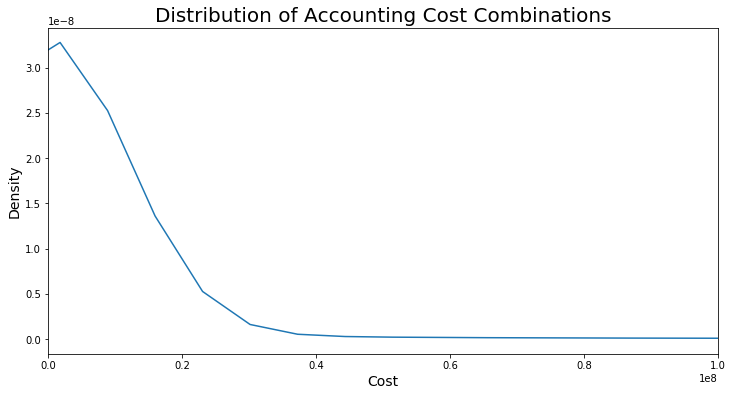

In [7]:
accounting_cost.stack().plot(kind='kde', figsize=(12,6))
plt.xlim(0,100_000_000)
plt.title('Distribution of Accounting Cost Combinations', fontsize=20)
plt.ylabel('Density', fontsize=14)
plt.xlabel('Cost',fontsize=14)
plt.show()

### Insight #3:

#### Time for the accounting cost.

Santa : "You mean accounting cost alone can cost me more than **$100 millions** if we don't manage the tour capacity properly??"

The Accountant : "Yeah, that is technically possible, but pretty unlikely, given the long-tail distribution ... * blah blah something something statistics *..."

Santa, interrupting impatiently : "OK, just make sure it doesn't happen."

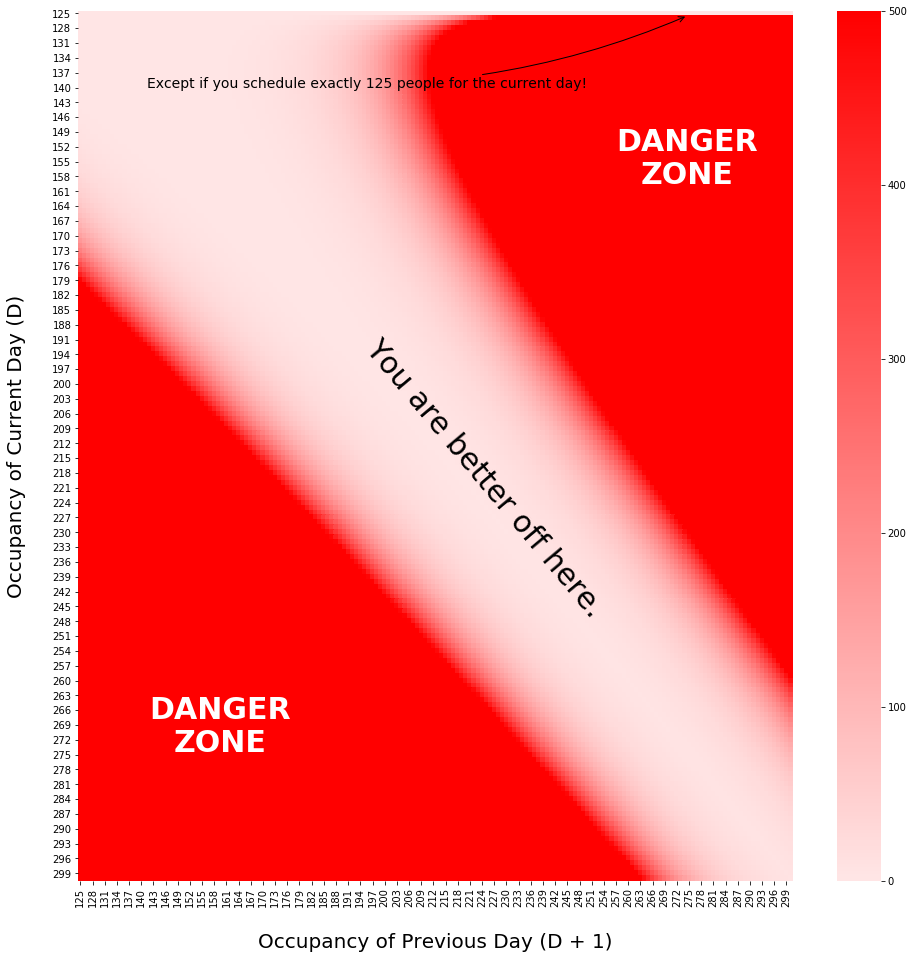

In [8]:
plt.figure(figsize=(16,16))
ax = sns.heatmap(accounting_cost, vmax = 500, cmap=sns.light_palette("red", n_colors=1000))

ax.annotate('DANGER\nZONE', (150, 35), color='white', fontsize=30, fontweight='heavy',ha='center')
ax.annotate('DANGER\nZONE', (35, 150), color='white', fontsize=30, fontweight='heavy',ha='center')
ax.annotate('You are better off here.', (100, 70), color='black', fontsize=30, ha='center', rotation = -50)
ax.annotate('Except if you schedule exactly 125 people for the current day!', (150, 1), 
            textcoords ='offset points',
            xytext =(-100,-75), 
            ha='right',
            va='bottom', 
            fontsize=14, 
            color='black',
            arrowprops=dict(arrowstyle='->', 
                            connectionstyle='arc3,rad=0.1', 
                            color='black'))

plt.ylabel('Occupancy of Current Day (D)\n', fontsize=20)
plt.xlabel('\nOccupancy of Previous Day (D + 1)', fontsize=20)
plt.show()

### Insight #4:

- Make sure the number of people attending everyday is well-balanced (Santa : "Isn't that common sense?")
- And if you are unable to do so, make sure the increase or decrease happens GRADUALLY over the days (Santa : "Ok that is pretty ambiguous, but let's stick to that for now")
- NEVER goes from full house today to the minimum capacity the next day, AVOID the **DANGER ZONE** unless... (Santa : "Hmm-hmm?")
- You can get exactly 125 people to attend the next day. (Santa : "Alright sounds do-able for the Kagglers I engaged!")

In [9]:
print(f'Max accounting cost for the first day : ${calculate_daily_accounting_cost(300,300):.2f}')

Max accounting cost for the first day : $7.58


### Insight #5:

Santa : "What about the first day? The Tax Authority promised me a special discount for my opening day!"

The Accountant : "Yeah, we only need to pay $7.58 at most!"

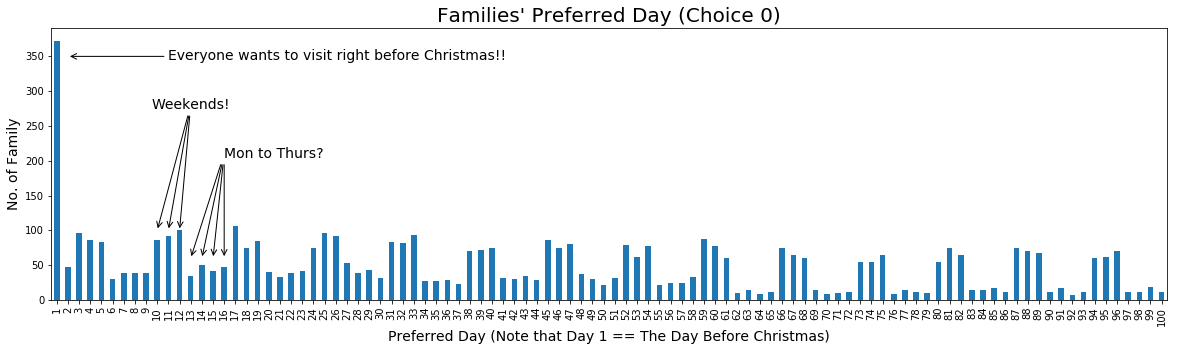

In [10]:
for i in range(1,2):
    df.iloc[:,i]\
        .value_counts()\
        .sort_index()\
        .plot(kind='bar', figsize=(20,5), color=f'C{i-1}')
    
    
    for x in range(9,16):
        if x > 11:
            y_offset = 200
            x_offset = 15
            y_max = 60
        else:
            y_offset = 270
            x_offset = 12
            y_max = 100

        if x == 10:
            s = 'Weekends!'
            plt.annotate(s,
                     (x, y_max), 
                     textcoords ='data',
                     xytext =(x_offset,y_offset), 
                     ha='center',
                     va='bottom', 
                     fontsize=14, 
                     color='black')
        elif x == 14:
            s = 'Mon to Thurs?'
            plt.annotate(s,
                     (x, y_max), 
                     textcoords ='data',
                     xytext =(x_offset,y_offset), 
                     ha='left',
                     va='bottom', 
                     fontsize=14, 
                     color='black')
        
        plt.annotate(' ',
                     (x, y_max), 
                     textcoords ='data',
                     xytext =(x_offset,y_offset), 
                     ha='center',
                     va='bottom', 
                     fontsize=14, 
                     color='black',
                     arrowprops=dict(arrowstyle='->', 
                                     color='black'))
    
    
    plt.annotate('Everyone wants to visit right before Christmas!!', 
                 (1, 350), 
                 textcoords ='offset points',
                 xytext =(100,0), 
                     ha='left',
                     va='center', 
                     fontsize=14, 
                     color='black',
                     arrowprops=dict(arrowstyle='->', 
                                     color='black'))
    
    plt.title(f"Families' Preferred Day (Choice 0)", fontsize=20)
    plt.xlabel('Preferred Day (Note that Day 1 == The Day Before Christmas)', fontsize=14)
    plt.ylabel('No. of Family', fontsize=14)
    plt.show()

### Insight #6:

Santa : "I knew everyone is eager to tour my workshop! Everyone wants to visit on Day 1! And it seems like weekends gonna be our busy days!"

The Accountant : "Yes, but PLEASE remember we got to smooth out the tour capacity or we could incur MILLIONS in accounting"

@somnambWI : "WAIT, YOU ARE WRONG! Day 1 is the day before Christmas!"

Santa, in disbelief: "OH NO! How can I deliver the toys on time then. I should find someone to lead the tour on Christmas Eve! Or maybe we should look into assigning the families their other choices?"

The Accountant : "Well, the other choices are pretty much the same... Same distribution, everybody wants to visit on Christmas Eve."

Santa : "Someone else to lead the tour, that is!" 

### That's all for now! 